# Backpropagation on DAGs

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/fundamentals/backpropagation.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)


---

## Introduction

In this notebook, we will look at **backpropagation** (BP) on computational **directed acyclic graphs** (DAG). Our main result is that a training step for a single data point (consisting of both a forward and a backward pass) has a time complexity that is linear in the number of edges of the graph. This result is interesting since it turns out that neural networks are fundamentally just computational DAGs.

<!-- In the last section, we take a closer look at the implementation of `.backward` in PyTorch. -->

**References**
* [Evaluating $\nabla f(x)$ is as fast as $f(x)$](https://timvieira.github.io/blog/post/2016/09/25/evaluating-fx-is-as-fast-as-fx/)
* [Back-propagation, an introduction](http://www.offconvex.org/2016/12/20/backprop/)
* [PyTorch Autograd Explained - In-depth Tutorial](https://www.youtube.com/watch?v=MswxJw-8PvE)
* [Topological Sort of Directed Acyclic Graphs](https://www.baeldung.com/cs/dag-topological-sort)
* [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)

## Gradient descent on the loss surface

For every data point $(\mathbf x, y)$, the loss function $\mathcal L$ assigns a nonnegative number $\mathcal L(y, f_{\boldsymbol \Theta}(\mathbf x))$ that approaches zero whenever the predictions $f_{\boldsymbol \Theta}(\mathbf x)$ approach the target values $y$. Given the current parameters $\boldsymbol \Theta \in \mathbb R^d$ of a neural network $f,$ we can imagine the network to be at a certain point $(\boldsymbol \Theta, \mathcal L_{\mathcal X}(\boldsymbol \Theta))$ on a surface in $\mathbb R^d \times \mathbb R$ where $\mathcal L_{\mathcal X}(\boldsymbol \Theta)$ is the average loss over the dataset:

$$
\mathcal L_{\mathcal X}(\boldsymbol \Theta) = \frac{1}{|\mathcal X|} \sum_{(\mathbf x, y) \in \mathcal X} \mathcal L(y, f_{\boldsymbol \Theta}(\mathbf x)).
$$

The empirical loss acts as an almost-everywhere differentiable surrogate to the true objective (e.g. a non-differentiable metric such as accuracy). This will generally vary for each sample, hence the subscript. Nevertheless, we except these surfaces to be very similar assuming the samples are drawn from the same distribution. Training a neural network is equivalent to finding the minimum of this surface. The first derivatives give us information about the local slope of the surface which we can use to make the first-order approximation 

$$\Delta \mathcal L_{\mathcal X} \approx  \sum_k \left(\frac{\partial \mathcal L_{\mathcal X}}{ \partial \Theta_k} \right)  \Delta \Theta_k = \left(\nabla_{\boldsymbol \Theta}\, \mathcal L_{\mathcal X}\right) \cdot \Delta {\boldsymbol\Theta}.$$ 

Then, the direction of steepest descent at the current point in the surface is $-\nabla_{\boldsymbol \Theta}\, \mathcal L_{\mathcal X}.$ Hence, the update rule used for network weights is $\boldsymbol \Theta \leftarrow \boldsymbol \Theta - \varepsilon \nabla_{\boldsymbol \Theta}\, \mathcal L_
{\mathcal X}.$ where $\varepsilon > 0$ called the learning rate is a constant that controls the step size. Since this uses a fixed factor for all directions, the resulting weights can potentially overshoot the minimum in some directions. This explains why second-order methods which uses second derivatives, i.e. the [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix), to measure local surface curvature are used. Since this is impractical to compute for large number of weights, the approach used in practice is to instead use [adaptive learning rates](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/04-tensorflow-optim-init.html#optimization-algorithms).

**Remark.** Note that since the loss is a sum over pointwise losses, it suffices to compute gradients for loss surfaces generated by a single input-output pair $(\mathbf x, y) \in \mathcal X$ to compute the gradient of the empirical loss over $\mathcal X$ by linearity of $\nabla_{\boldsymbol \Theta}.$


```{figure} ../../img/loss_surface_resnet.png
---
name: loss-surface-resnet
width: 35em
---
Loss surface for ResNet-56 with or without skip connections. Much of deep learning research is dedicated to studying the geometry of loss surfaces and its effect on optimization. {cite}`arxiv.1712.09913`
```



```{margin}
**The need for efficient BP**
```

Observe that $\nabla_{\boldsymbol \Theta}\, \mathcal L_{\mathcal X}$ consists of partial derivatives for each weight in the network which can easily number in millions. Thus, we will perform computation of derivatives in an efficient way for this training with gradient-based methods to be feasible. It turns out that we can perform this with time complexity that is linear with the number of weights. Furthermore, the development of sophisticated hardware for parallel computation (e.g. GPUs) has reduced training time by a significant factor, resulting in the viability of neural network models for pratical uses.

## Backpropagation on computational graphs

A neural network can be modelled as a directed acyclic graph (DAG) of compute and parameter nodes that implements a function $f$ and can be extended to implement the calculation of the loss value for each training example and parameter values. Note that we can always perturb the value of the loss node at the current state of the graph (i.e. the current values of its nodes) by perturbing the values in each node. This results in perturbations flowing up to the final loss node. Assuming each computation is differentiable, we can compute the partial derivative of the loss with respect to each graph node. In this section, we will look at an algorithm for computing partial derivatives of computational graphs.

Our computational DAGs will consist of **compute nodes** and **parameter nodes**. A compute node simply implements a function of values of nodes that are directed to it. This doesn't have to implement atomic functions. In fact, we will implement compute nodes at various levels of abstraction. The choice generally depends on design considerations. On the other hand, parameter nodes simply store values which ultimately determines the function $f.$ Hence, our goal is to modify the parameter node values that minimizes the empirical loss.

We will use the fundamental property of DAGs that it has a **topological sorting**. Observe that a DAG always has a node that has no outgoing edges (just follow a path until the last node). For our purposes, we know that this is precisely the loss node of our graph. Then, we can perform [BFS](https://en.wikipedia.org/wiki/Breadth-first_search) starting with the loss node to determine the "layers" of the DAG, i.e. the order index of each node in the topological sorting.

```{figure} ../../img/compute.svg
---
width: 30%
name: compute
---
Compute and parameter node as input to another compute node. Note that parameter nodes always have zero fan-in.
```

### Forward pass

To compute $f(\mathbf x)$, the input $\mathbf x$ is passed to the input nodes, then all compute nodes are executed up to the loss node following the directions and operations specified by the nodes and their edges. Note that node executions can occur asynchronously, e.g. in parallel. Moreover, each compute node is executed exactly once with the output value stored in the node. This will preserve the current network state for backward pass, and avoids any recomputation for nodes in the next layer. So assuming a node with $n$ inputs executes $n$ operations, then one forward pass takes $\mathcal{O}(E)$ calculations were $E$ is the number of edges of the graph. For neural networks the number of edges is proportional to the number of weights and activation units of the network.

### Backward pass

During backward pass gradients are categorized into two types: **local gradients** which are derivatives between adjacent nodes, and derivatives of the loss with respect to the node called **backpropagated gradients** since it is propagated backward from the loss node into the current node. Recall from above that our goal is to calculate the backpropagated gradient of the loss with respect to each parameter node.

**BP proceeds recursively.** We will assume that the graph has been topologically sorted. For neural networks, there is no need to do this since we already have a natural ordering defined by the layers. 
For the base step, the gradient of the compute node for the loss is set to $1$ (i.e. its derivative with itself) and stored in memory. Iterating backwards in the sorted list of nodes, we know that the backpropagated gradient for each compute node $v$ that depends on $u$ is already stored. Moreover, all local gradients between $u$ and $v$ are [computable at runtime](https://en.wikipedia.org/wiki/Automatic_differentiation). Then, the backpropagated gradient with respect to node $u$ can be calculated using the chain rule:

$$
{\frac{\partial\mathcal L}{\partial u} } = \sum_{ {v} } \left( {{\frac{\partial\mathcal L}{\partial v}}} \right) \left( {{\frac{\partial{v}}{\partial u}}} \right).
$$

Note that gradient type is distinguished by color in the figure below:


```{figure} ../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the backpropagated gradient for a single node.
```

This can be visualized as gradients "flowing" to each network node from the loss node. Observe that the flow of gradients end on parameter nodes since these nodes have zero fan-in. Here the partial derivatives are evaluated on the current network state with values obtained during forward pass. Hence, forward pass should always precede backward pass. Moreover, as required by the algorithm all backpropagated gradients are stored in each compute node for use by the next layer. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients; these are computed as needed. 
    
**Remark.** BP is a useful tool for understanding how derivatives flow through a model. This can be extremely helpful in reasoning about why some models are difficult to optimize. Classic examples are vanishing or exploding gradients as we go into deeper layers of the network.

### Backpropagation algorithm

Now that we know how to compute each backpropagated gradient, we can implement this as a method `u.backward()` for each node `u` that sends the gradient of the loss with respect to `u` to all nodes that depend on it. Every backpropagated gradient that is sent to a node is accumulated in a sum. Hence, we have to zero it out at the start of every trainng step.

```python
class CompGraph:
    # ...

    def forward(self, inputs):
        self.graph.input_nodes.pass(inputs)
        
        for node in self.graph.nodes_toposorted():
            node.forward()


    def backward():
        for node in self.nodes():
            node.grad = 0

        for node in reversed(self.graph.nodes_toposorted()):
            node.backward()

```

<br>

Properties of the algorithm which makes it the practical choice for training huge neural networks are:

* **Modularity.** For neural networks, the dependence only on nodes belonging to the upper layer suggests a modularity in implementing neural networks, i.e. we can connect DAG subnetworks with possibly distinct network architectures by only connecting outermost nodes that are exposed between layers.

<br>

* **Efficiency.** Iterating over all nodes in the network during backward pass covers all the edges in the network with no edge counted twice. Assuming computing local gradients take constant time, then backward pass requires ${\mathcal O}(E)$ computations. For neural networks this is proportional to the number of neurons and parameters (i.e. the network size). Furthermore, the chain rule between nodes on the same layer and nodes in the upper layer of a network can be implemented as matrix multiplication for which there exist [highly optimized implementations](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms). This is done in the next section.

### Model training from scratch

In this section, we will attempt an implementation of an actual computational graph with nodes that implement `backward`.

In [85]:
import math

class Node:
    def __init__(self, data, label='', _children=(), _op=''):
        self.data = data
        self.label = label
        self.grad = 0
        self._op = _op
        self._children = _children

    def __repr__(self):
        return f"Node(data={self.data}, label={self.label}, grad={self.grad})"

    def backward(self):
        return 0 # i.e. do nothing for leaf nodes

    def __add__(self, other):
        return BinaryComputeNode(self, other, _op='+')

    def __sub__(self, other):
        return BinaryComputeNode(self, other, _op='-')

    def __mul__(self, other):
        return BinaryComputeNode(self, other, _op='*')

    def __pow__(self, n):
        assert isinstance(n, int)
        assert n > 1
        return PowComputeNode(self, n)

    def relu(self):
        return ReLUComputeNode(self)

    def tanh(self):
        return TanhComputeNode(self)


class BinaryComputeNode(Node):
    def __init__(self, x, y, _op='', label=None):
        # Implemented ops
        out = {
            '+': x.data + y.data,
            '-': x.data - y.data,
            '*': x.data * y.data,
        }
        if not label:
            label = f'({x.label} {_op} {y.label})'
        super().__init__(out[_op], label, (x, y), _op)

    def backward(self):
        """Pushing global gradient to child nodes 
        scaled with resp. local derivative (chain rule)."""
        
        if self._op == '+':
            x, y = self._children
            x.grad += self.grad * 1.0
            y.grad += self.grad * 1.0
            x.backward()
            y.backward()
        
        elif self._op == '-':
            x, y = self._children
            x.grad += self.grad * 1.0
            y.grad -= self.grad * 1.0
            x.backward()
            y.backward()
        
        elif self._op == '*':
            x, y = self._children
            x.grad += self.grad * y.data
            y.grad += self.grad * x.data
            x.backward()
            y.backward()
            

class ReLUComputeNode(Node):
    def __init__(self, x):
        out = x.data * int(x.data > 0.0)
        super().__init__(out, f'relu({x.label})', (x,), 'relu')

    def backward(self):
        """Pushing global gradient to child node
        scaled with local derivative (chain rule)."""
        
        x = self._children[0]
        x.grad += self.grad * float(x.data > 0)
        x.backward()


class TanhComputeNode(Node):
    def __init__(self, x):
        out = math.tanh(x.data)
        super().__init__(out, f'tanh({x.label})', (x,), 'tanh')

    def backward(self):
        """Pushing global gradient to child node
        scaled with local derivative (chain rule)."""
        
        x = self._children[0]
        x.grad += self.grad * (1 - math.tanh(x.data)**2)
        x.backward()


class PowComputeNode(Node):
    def __init__(self, x, n):
        self.n = n
        out = x.data ** n
        super().__init__(out, f'({x.label})**{self.n}', (x,), 'pow')

    def backward(self):
        """Pushing global gradient to child node
        scaled with local derivative (chain rule)."""
        
        x = self._children[0]
        x.grad += self.grad * self.n * x.data ** (self.n-1)
        x.backward()

To visualize networks, we will use `graphviz`:

In [86]:
from graphviz import Digraph
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb


def trace(root):
    """Builds a set of all nodes and edges in a graph."""

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:

        # Add node to graph    
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label} | data={n.data:.3f} | grad={n.grad:.4f}", shape='record')
        
        # If node is a result of computation, create op node for it
        # Then, connect n to op node, 
        # e.g. if 5 = 2 + 3, then draw [5] as [+ -> 5].
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + v._op)
    
    return dot

Forward pass for a dense unit:

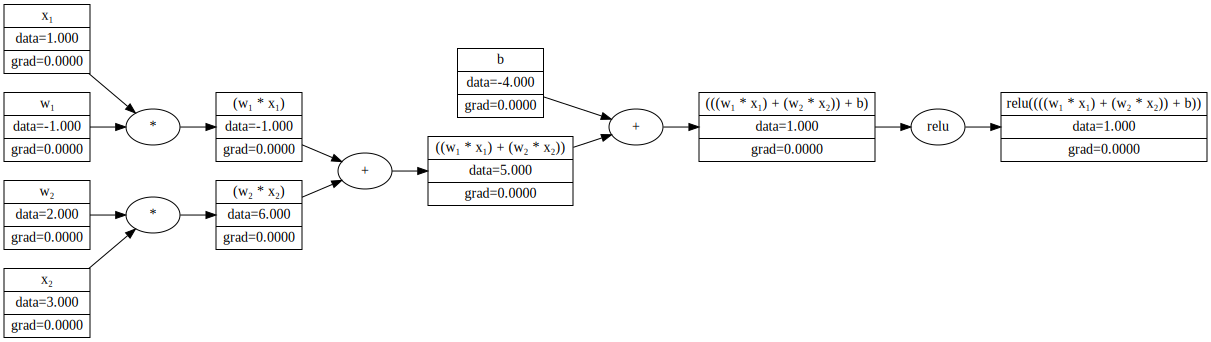

In [87]:
w1 = Node(-1.0, label='w₁')
x1 = Node( 1.0, label='x₁')
w2 = Node( 2.0, label='w₂')
x2 = Node( 3.0, label='x₂')
b  = Node(-4.0, label='b' )

z = w1 * x1 + w2 * x2 + b
y = z.relu()
draw_graph(y)

Backward pass. Observe that all gradients check out.

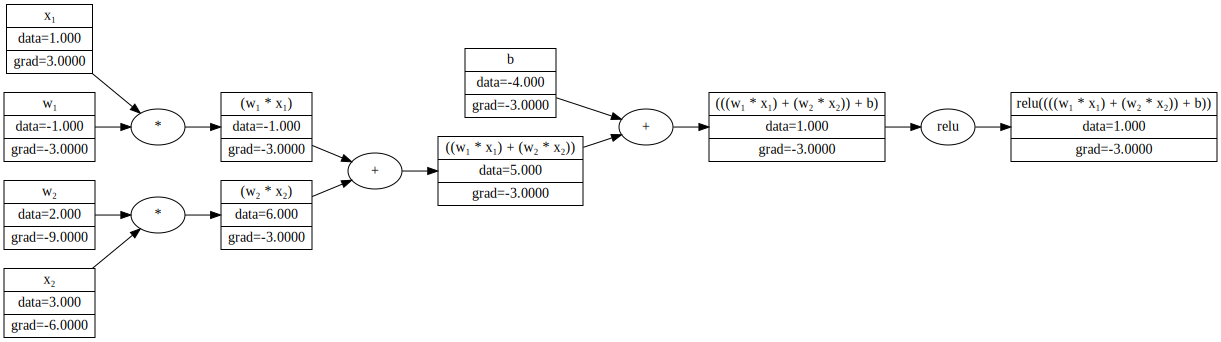

In [88]:
y.grad = -3.0
y.backward()
draw_graph(y)

To train a neural network which computes a function $f,$ we can think of wrapping the original network in a computational graph that adds an additional input node for the target values, and an additional compute node for the loss function which takes in the network output $f(\mathbf x)$ and target $y$ given an input output pair $(\mathbf x, y)$ in a training step. Note that we can use any algorithm to update network weights. The following training loop implements [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with $\epsilon = 0.01.$ 

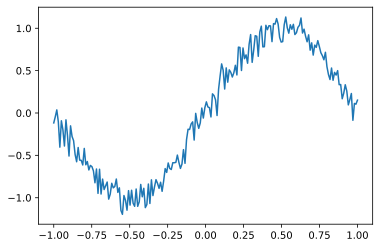

In [89]:
import random as pyrandom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

N = 200
x = np.linspace(-1, 1, N)
y = np.sin(np.pi*x) + 0.1*np.random.normal(size=N)
plt.plot(x, y);

dataset = list(zip(list(x), list(y)))

We will implement a fully-connected neural network with 1-3-2-1 units with ReLU activations in the hidden layers.

In [120]:
w11 = Node(pyrandom.random(), label='w₁₁')
w12 = Node(pyrandom.random(), label='w₁₂')
w13 = Node(pyrandom.random(), label='w₁₃')
b1  = Node(0.0, label='b₁' )
b2  = Node(0.0, label='b₂' )
b3  = Node(0.0, label='b₃' )

u11 = Node(pyrandom.random(), label='u₁₁')
u21 = Node(pyrandom.random(), label='u₂₁')
u31 = Node(pyrandom.random(), label='u₃₁')
u12 = Node(pyrandom.random(), label='u₁₂')
u22 = Node(pyrandom.random(), label='u₂₂')
u32 = Node(pyrandom.random(), label='u₃₂')
c1  = Node(0.0, label='c₁')
c2  = Node(0.0, label='c₂')

v11 = Node(pyrandom.random(), label='v₁₁')
v21 = Node(pyrandom.random(), label='v₂₁')
d1  = Node(0.0, label='d₁')


def f(x):
    h1 = x * w11 + b1; h1.label = 'h₁'
    h2 = x * w12 + b2; h2.label = 'h₂'
    h3 = x * w13 + b3; h3.label = 'h₃'

    z1 = h1.tanh() * u11 + h2.tanh() * u21 + h3.tanh() * u31 + c1; z1.label = 'z₁'
    z2 = h1.tanh() * u12 + h2.tanh() * u22 + h3.tanh() * u32 + c2; z2.label = 'z₂'
    
    out = z1 * v11 + z2 * v21 + d1; out.label = 'out'
    return out


def zero_grad(root):
    nodes = trace(root)[0]
    for node in nodes:
        node.grad = 0.0

def apply_sgd(root):
    nodes = trace(root)[0]
    for node in nodes:
        node.data -= 0.0001 * node.grad

def loss_fn(out, y):
    return (out - y)**2

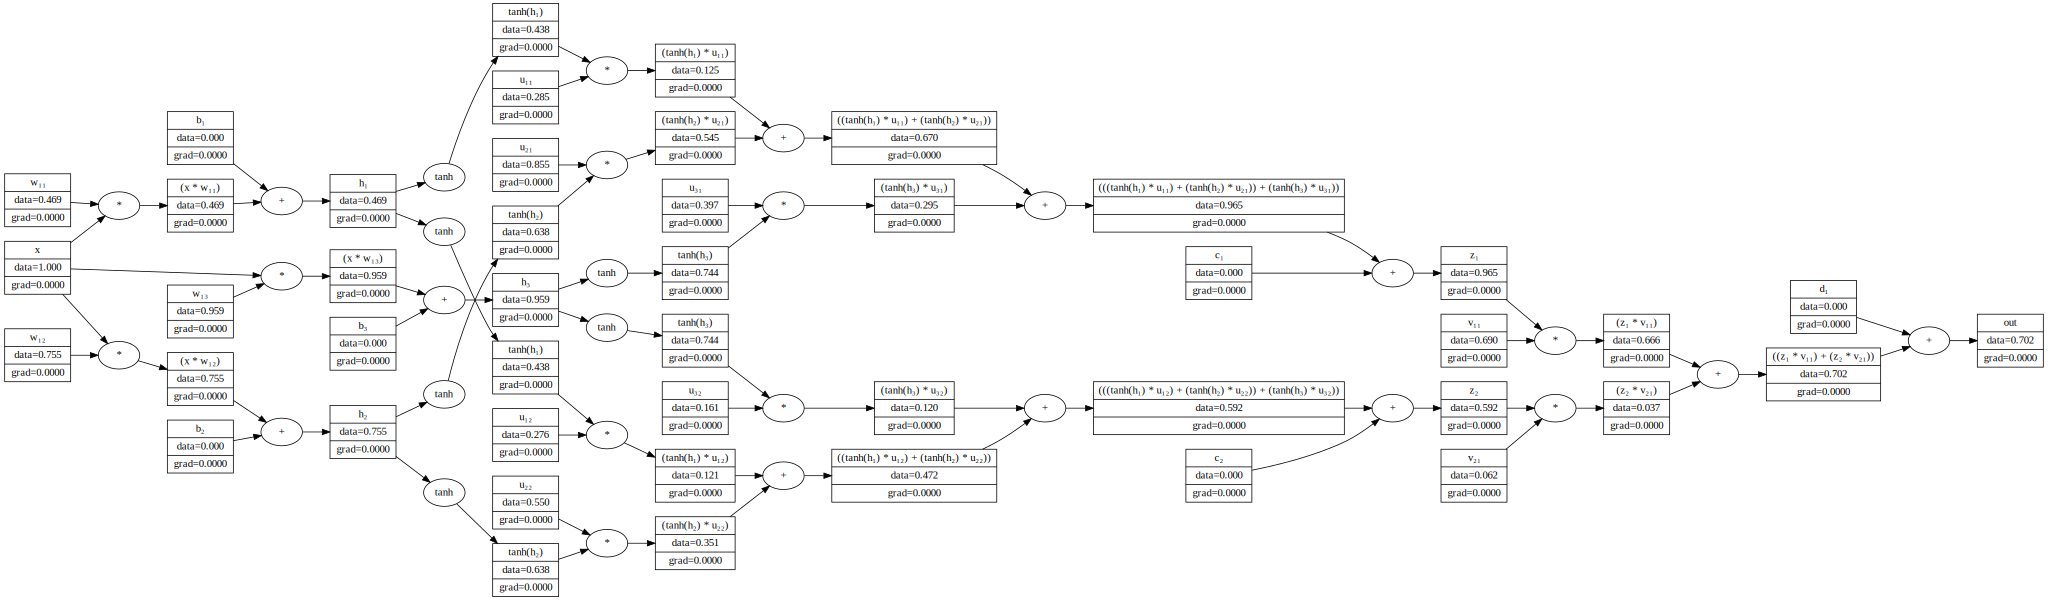

In [121]:
draw_graph(f(Node(1.0, label='x')))

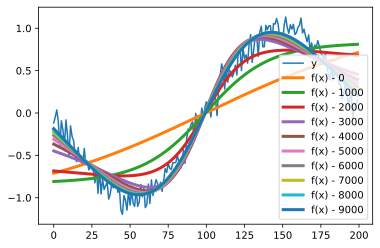

In [125]:
inputs = [u for u, v in dataset]
output = [v for u, v in dataset]
model_out = [f(Node(_)).data for _ in inputs]
preds = {0: model_out}

hist = []
for _ in range(10000):
    shuffled = pyrandom.sample(dataset, N)
    avg_loss = 0.0
    for i in range(N // 10):
        minibatch = shuffled[i * 10: (i + 1) * 10]  # Get minibatch of size 10
        for x_, y_ in minibatch:
            x = Node(x_, label='x')
            y = Node(y_, label='y')

            out = f(x)
            zero_grad(out)
            loss = loss_fn(out, y)
            loss.grad = 1.0
            loss.backward()
            apply_sgd(out)
            avg_loss += loss.data
    
    hist.append(avg_loss / N)
    if (_ % 1000) == 0:
        preds[_] = [f(Node(_)).data for _ in inputs]

plt.show()
plt.plot(output, label='y')
for k in preds.keys():
    plt.plot(preds[k], label=f'f(x) - {k}', linewidth=3.0)
plt.legend();

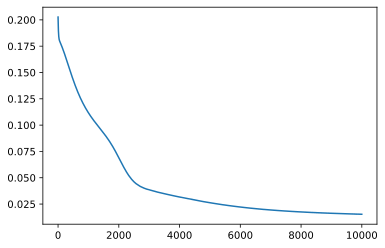

In [132]:
plt.plot(hist);

## BP equations for MLPs

```{margin}
Source:<br>**Figure 1** of {cite}`0483bd9444a348c8b59d54a190839ec9`
```
```{figure} ../../img/deep-nns.png
---
width: 40em
---

**Figure 1** of {cite}`0483bd9444a348c8b59d54a190839ec9` should hopefully make sense after reading this article. This figure shows (left) forward pass for a multilayer neural network, and (right) backward pass for the same network.
```

In this section, we solve the BP equations for a densely connected neural network. This can be useful for looking gradient flow analytically. As shown in the above figure, a multilayer neural network can be modelled as a computational DAG. Note that we use row vectors to represent input and output in the equations below. Computation performed by the network at layer $t$ can be written in two steps as:

* ${\mathbf{y}}^{[l]} = {\mathbf{x}}^{[l-1]}{\boldsymbol{W}}^{[l]} + {\boldsymbol b}^{[l]}$ 
* ${\mathbf x}^{[l]} = \varphi({\mathbf y}^{[l]})$ 

Here we use row vectors for layer inputs and outputs. The following equations are obtained by simply matching input and output shapes, then trying to figure out the entries of the right hand side matrix by tracking node dependencies. For the compute nodes in the current layer, the BP equations are:
    
$$
\dfrac{\partial \mathcal L}{\partial {\mathbf x}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {\mathbf y}^{[l+1]}} 
\dfrac{\partial {\mathbf y}^{[l+1]}}{\partial {\mathbf x}^{[l]}} 
=
\dfrac{\partial \mathcal L}{{\partial \mathbf{y}}^{[l+1]}}
\boldsymbol{W}^{[l+1]\top}
$$

and

$$
\dfrac{\partial \mathcal L}{\partial {{\mathbf y}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {\mathbf x}^{[l]}} 
\dfrac{\partial {\mathbf x}^{[l]}}{\partial {\mathbf y}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{{\partial \mathbf{x}}^{[l]}}
{{\boldsymbol J}_\varphi}{^{[l]}}.
$$

Here the Jacobian matrix is defined as $\left({\boldsymbol J}_{\varphi}\right)_{ij} = \frac{\partial x_i}{\partial y_j}$. For commonly used activations, i.e. those which are applied entrywise on vector inputs, the Jacobian reduces to a diagonal matrix. The backpropagated gradients for parameter nodes are:

$$
\dfrac{\partial \mathcal L}{\partial {\boldsymbol W}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\mathbf y}}^{[l]}} 
\dfrac{\partial {{\mathbf y}}^{[l]}}{\partial {\boldsymbol W}^{[l]}} 
= 
\mathbf{x}^{[l-1]\top}
\dfrac{\partial \mathcal L}{\partial {{\mathbf y}}^{[l]}} 
$$

and

$$
\dfrac{\partial \mathcal L}{\partial {\boldsymbol{b}_{j}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\mathbf y}}^{[l]}}
\dfrac{\partial {{\mathbf y}}^{[l]}}{\partial {\boldsymbol b}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\mathbf y}}^{[l]}}.
$$

Backpropagated gradients for compute nodes have to be stored until weights are updated. Observe that derivatives of the compute nodes of layer $l+1$ are retrieved to compute gradients in layer $l.$ On the other hand, the local gradients ${\boldsymbol J}_\varphi$ are computed using autodifferentiation and are evaluated at the current network state based on values obtained at forward pass.

<br>

```{figure} ../../img/jacobian.svg
---
name: jacobian
width: 75%
---
Deriving the equations by matching shapes of derivatives as matrices. In general, we put the incoming gradients as input, and current gradients as output. What is left is to figure out the matrix in between containing the appropriate local derivatives.
```


## TensorFlow Autodiff

The above equations and process is demonstrated in the following computation:

In [8]:
import tensorflow as tf
print(tf.__version__)

# Input and weight init.
x0 = tf.Variable(tf.random.normal(shape=(1, 4)))
W1 = tf.Variable(tf.random.normal(shape=(4, 3)))
b1 = tf.Variable(tf.random.normal(shape=(1, 3)))
W2 = tf.Variable(tf.random.normal(shape=(3, 2)))

2.9.2
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-28 01:49:58.433892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-28 01:49:58.434006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Forward:
with tf.GradientTape(persistent=True) as tape:
    y1 = tf.matmul(x0, W1) + b1
    x1 = tf.keras.activations.softmax(y1)

    y2 = tf.matmul(x1, W2)
    L = tf.reduce_sum(y2**2)

# Backward:
# (1) ∂L/∂x[t] = ∂L/∂y[t+1] W[t+1]
# Fetch ∂L/∂y[t+1] from upper layer.
L_x1 = tf.matmul(tape.gradient(L, y2), tf.transpose(W2))

# (2) ∂L/∂y[t] = ∂L/∂x[t] J[t]
# Compute local gradients using autodiff.
L_y1 = tf.matmul(L_x1, tf.reshape(tape.jacobian(x1, y1), (3, 3)))

# (3) ∂L/∂W[t] = x[t-1]T ∂L/∂y[t]
L_W1 = tf.matmul(tf.transpose(x0), L_y1)

# (4) ∂L/∂b[t] = ∂L/∂y[t]
L_b1 = L_y1

print("(weights)")
print("TF autodiff:")
print(tape.gradient(L, W1).numpy())
print("\nBP equations:")
print(L_W1.numpy())

print("\n(biases)")
print("TF autodiff: ", tape.gradient(L, b1).numpy())
print("BP equations:", L_b1.numpy())

(weights)
TF autodiff:
[[-0.02551604  0.00109216  0.02442426]
 [ 0.01623343 -0.00069484 -0.01553884]
 [ 0.01366194 -0.00058477 -0.01307738]
 [-0.02030785  0.00086924  0.01943892]]

BP equations:
[[-0.02551604  0.00109216  0.02442409]
 [ 0.01623344 -0.00069484 -0.01553873]
 [ 0.01366195 -0.00058477 -0.01307729]
 [-0.02030786  0.00086924  0.01943879]]

(biases)
TF autodiff:  [[-0.02342275  0.00100256  0.02242054]]
BP equations: [[-0.02342275  0.00100256  0.02242038]]


2022-08-28 01:49:59.067667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-28 01:49:59.068169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<!-- ## Autodifferentiation with PyTorch `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined in above for BP.

<br>

**Backward for scalars.** Let $y = \mathbf x^\top \mathbf x = \sum_i {x_i}^2.$ In this example, we initialize a tensor `x` which initially has no gradient. Calling backward on `y` results in gradients being stored on the leaf tensor `x`.  -->

<!-- x = torch.arange(4, dtype=torch.float, requires_grad=True)
y = x.T @ x 

y.backward() 
(x.grad == 2*x).all() -->

<!-- **Backward for vectors.** Let $\mathbf y = g(\mathbf x)$ and let $\mathbf v$ be a vector having the same length as $\mathbf y.$ Then `y.backward(v)` implements   

$$\sum_i v_i \left(\frac{\partial y_i}{\partial x_j}\right)$$ 
  
resulting in a vector of same length as `x` that is stored in `x.grad`. Note that the terms on the right are the local gradients in backprop. Hence, if `v` contains backpropagated gradients of nodes that depend on `y`, then this operation gives us the backpropagated gradients with respect to `x`, i.e. setting $v_i = \frac{\partial \mathcal{L} }{\partial y_i}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial x_j}.$ -->

<!-- x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor(
    [[1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all() -->

<!-- **Locally disabling gradient tracking.** Disabling gradient computation is useful when computing values, e.g. accuracy, whose gradients will not be backpropagated into the network. To stop PyTorch from building computational graphs, we can put the code inside a `torch.no_grad()` context or inside a function with a `@torch.no_grad()` decorator.

Another technique is to use the `.detach()` method which returns a new tensor detached from the current graph but shares the same storage with the original one. In-place modifications on either of them will be seen, and may trigger errors in correctness checks. -->